# Turbofan POC - Data Analysis

This notebook is a compact analysis of the initial dataset for the turbofan POC based on the NASA turbofan dataset.

## Imports

In [2]:
# check if we are inside google colab
try:
    from google.colab import drive
    # mount gdrive for importing the data
    drive.mount('/content/gdrive', force_remount=True)
    # change this path to your notebooks directory inside google drive
    %cd /content/gdrive/My\ Drive/dev/turbofan_poc/notebooks

    # set tensorflow version
    %tensorflow_version 2.x
except:
    pass

In [3]:
import os
import numpy as np
import pandas as pd
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Data Import and Preparations

Let´s load the dataset with our initial training data.

In [4]:
# load the data 
dirname = os.getcwd()
data_path = os.path.join(dirname, '../data')
train_data_path = os.path.join(data_path, 'train_data_initial.txt')
train_data = pd.read_csv(train_data_path)
train_data.set_index('time_in_cycles')

train_data.sample(5)

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
1124,42,96,-0.0017,0.0002,100.0,518.67,642.53,1587.78,1401.27,14.62,...,8144.90,8.4533,0.03,393,2388,100.0,38.94,23.4342,NaN,NaN
963,56,210,-0.0014,-0.0001,100.0,518.67,643.24,1594.84,1417.75,14.62,...,8153.61,8.4566,0.03,394,2388,100.0,38.90,23.0961,NaN,NaN
885,56,132,-0.0013,0.0001,100.0,518.67,643.48,1589.91,1411.83,14.62,...,8139.28,8.4509,0.03,392,2388,100.0,38.86,23.2247,NaN,NaN
596,67,156,-0.0024,0.0005,100.0,518.67,642.32,1593.99,1411.75,14.62,...,8141.21,8.4250,0.03,395,2388,100.0,38.94,23.4137,NaN,NaN
669,67,229,0.0018,0.0004,100.0,518.67,642.76,1599.50,1417.09,14.62,...,8147.43,8.4453,0.03,394,2388,100.0,38.77,23.2146,NaN,NaN


There is an engine number defining the original engine data series, there is the current cycle and then there are 3 operational settings and 23 sensors.

Now we need to add the labels to the data calculating the max cycle per engine and then adding the current RUL per engine.

In [5]:
# retrieve the max cycles per engine: RUL
train_rul = pd.DataFrame(train_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
# merge the RULs into the training data
train_rul.columns = ['engine_no', 'max']
train_data = train_data.merge(train_rul, on=['engine_no'], how='left')
# add the current RUL for every cycle
train_data['RUL'] = train_data['max'] - train_data['time_in_cycles']
train_data.drop('max', axis=1, inplace=True)
train_data.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,RUL
0,81,1,-0.0050,0.0003,100.0,518.67,642.04,1589.91,1406.63,14.62,...,8.4455,0.03,391,2388,100.0,38.87,23.3365,NaN,NaN,239
1,81,2,0.0023,0.0002,100.0,518.67,642.65,1586.25,1407.88,14.62,...,8.4573,0.03,392,2388,100.0,38.91,23.3452,NaN,NaN,238
2,81,3,-0.0005,0.0005,100.0,518.67,642.55,1586.42,1396.40,14.62,...,8.4522,0.03,394,2388,100.0,39.04,23.3610,NaN,NaN,237
3,81,4,-0.0001,-0.0000,100.0,518.67,642.41,1594.89,1404.86,14.62,...,8.4403,0.03,392,2388,100.0,38.77,23.4206,NaN,NaN,236
4,81,5,0.0024,0.0002,100.0,518.67,643.41,1590.49,1409.58,14.62,...,8.3971,0.03,392,2388,100.0,39.04,23.3311,NaN,NaN,235


## Data Analysis

### Basic Information

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 1224
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   engine_no              1225 non-null   int64  
 1   time_in_cycles         1225 non-null   int64  
 2   operational_setting_1  1225 non-null   float64
 3   operational_setting_2  1225 non-null   float64
 4   operational_setting_3  1225 non-null   float64
 5   sensor_measurement_1   1225 non-null   float64
 6   sensor_measurement_2   1225 non-null   float64
 7   sensor_measurement_3   1225 non-null   float64
 8   sensor_measurement_4   1225 non-null   float64
 9   sensor_measurement_5   1225 non-null   float64
 10  sensor_measurement_6   1225 non-null   float64
 11  sensor_measurement_7   1225 non-null   float64
 12  sensor_measurement_8   1225 non-null   float64
 13  sensor_measurement_9   1225 non-null   float64
 14  sensor_measurement_10  1225 non-null   float64
 15  sens

In [7]:
# check how many original turbofan engine series we have
len(train_data['engine_no'].unique())

5

There are 5 complete time series of turbofan engine data.

We remove the empty sensors.

In [8]:
cols_nan = train_data.columns[train_data.isna().any()].tolist()
print('Columns without data: \n' + str(cols_nan) + '\n')

train_data = train_data.drop(columns=cols_nan)

Columns without data: 
['sensor_measurement_22', 'sensor_measurement_23']



In [9]:
# define column sets for the analysis
info_cols = ['engine_no', 'time_in_cycles', 'RUL']
operational_cols = ['operational_setting_{}'.format(i + 1) for i in range (3)]
sensor_cols = ['sensor_measurement_{}'.format(i + 1) for i in range(21)]

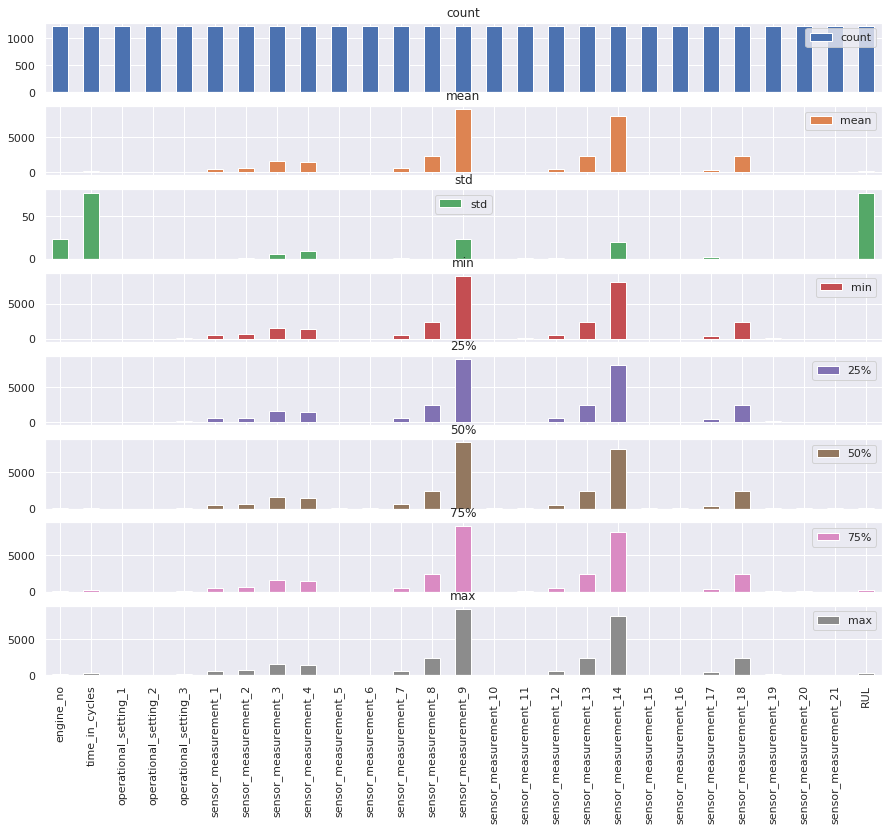

In [10]:
# plot an overview of whats going on in the columns
axes = train_data.describe().T.plot.bar(subplots=True, figsize=(15,12))

There are some sensors with constant constant values:

In [11]:
cols_const = [ col for col in train_data.columns if len(train_data[col].unique()) <= 2 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')

Columns with constant values: 
['operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']



### Correlations

Check the correlations:

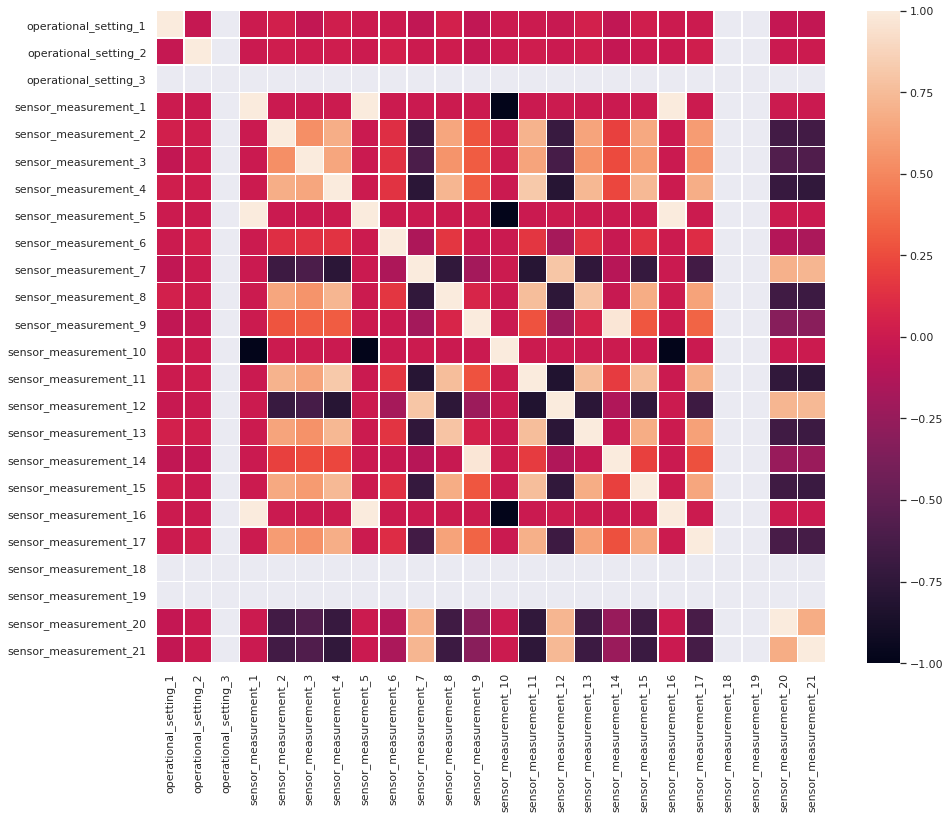

In [12]:
# print correlation heatmap
analysis_data_corr = train_data[operational_cols + sensor_cols].corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(analysis_data_corr, linewidths=.5)

In [13]:
# print highly correlated values
analysis_data_corr2 = pd.DataFrame(np.tril(analysis_data_corr.values), columns=analysis_data_corr.columns, index = analysis_data_corr.index)

correlating = []
for col in analysis_data_corr2.columns:
    ser = analysis_data_corr2[col]
    idx = np.logical_or(-0.8 > ser,  ser > 0.8)
    for i, c in zip(ser[idx].index, ser[idx].values):
        if (i, col, c) not in correlating and i != col:
            correlating.append((col, i, c))

print('Highly correlating values:')
for c in correlating:
    print(c)

Highly correlating values:
('sensor_measurement_1', 'sensor_measurement_5', 1.0)
('sensor_measurement_1', 'sensor_measurement_10', -1.0)
('sensor_measurement_1', 'sensor_measurement_16', 1.0)
('sensor_measurement_4', 'sensor_measurement_11', 0.8132231389952101)
('sensor_measurement_5', 'sensor_measurement_10', -1.0)
('sensor_measurement_5', 'sensor_measurement_16', 1.0)
('sensor_measurement_9', 'sensor_measurement_14', 0.9694564622489135)
('sensor_measurement_10', 'sensor_measurement_16', -1.0)
('sensor_measurement_11', 'sensor_measurement_12', -0.8254282797957002)


Sensor 1, 5, 10 and 16 have constant values so we can ignore these correlations.

### Time and Distribution Plots

We will start with plotting the sensor data for all engines in a row. 

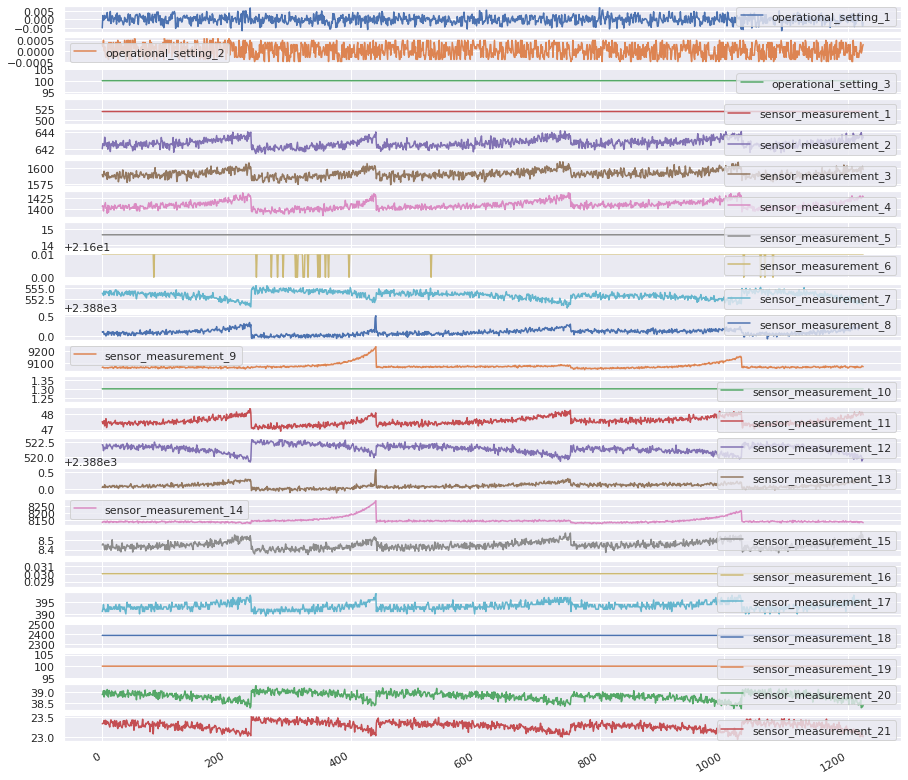

In [14]:
# plot all train data by sensors
t = train_data[operational_cols + sensor_cols].plot(subplots=True, figsize=(15, 15))

Now we plot the train data but grouped by our engines.

In [15]:
# inverse the RUL for the plot
train_data['RUL'] = train_data['RUL'] * -1

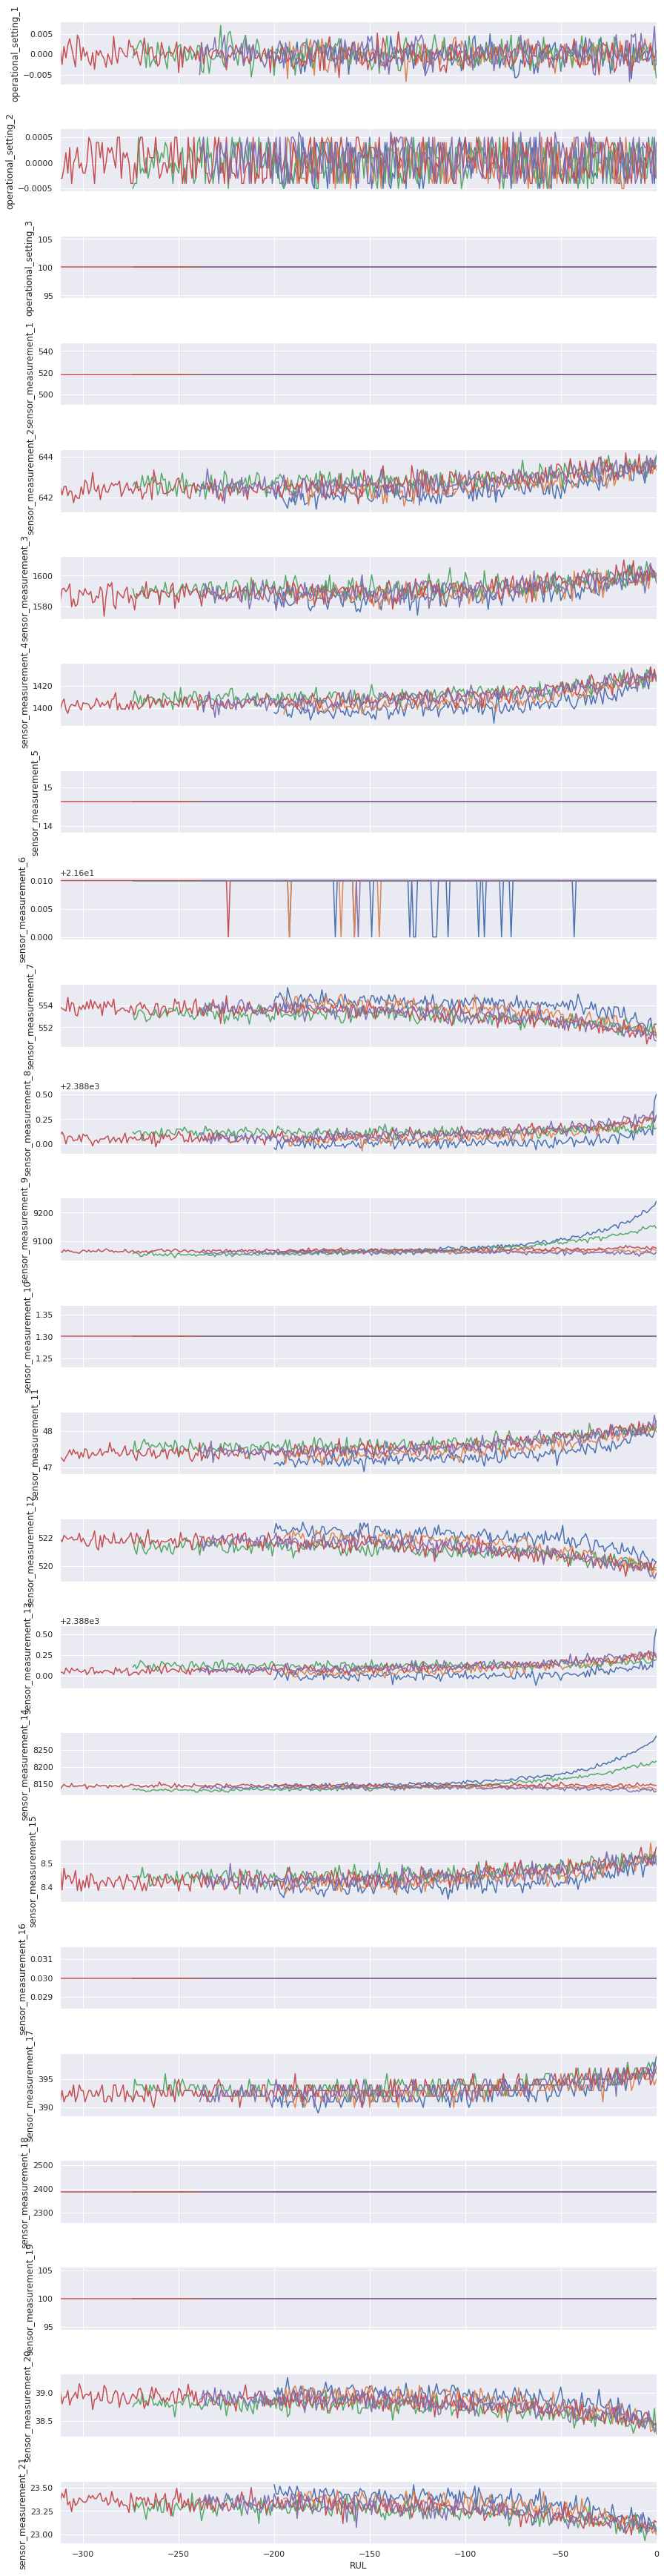

In [16]:
# plot all engines sensor data
g = sns.PairGrid(data=train_data, x_vars='RUL', y_vars=operational_cols+sensor_cols, hue="engine_no", height=2, aspect=6,)
g = g.map(plt.plot)
g = g.set(xlim=(train_data['RUL'].min(), train_data['RUL'].max()))

Let´s plot a single engine and try several engines.

In [100]:
engine_series_length = train_data.groupby(['engine_no'], sort=False)['time_in_cycles'].max().sort_values()
shortest_engine = engine_series_length.index[0]
longest_engine = engine_series_length.index[-1]

print("The engine with the shortest cycles is nr. {} with {} cycles lifetime and the one with the longest cycles run is nr. {} running {} cycles.".\
      format(shortest_engine, engine_series_length.iloc[0], longest_engine, engine_series_length.iloc[-1]))

The engine with the shortest cycles is nr. 42 with 196 cycles lifetime and the one with the longest cycles run is nr. 67 running 313 cycles.


In [18]:
# plot a single engines sensor data
def plot_engine_data(engine_no, engine_data):
  window_size = 20
  cols = engine_data.columns
  fig, axes = plt.subplots(len(cols), 1, figsize=(15,12))

  for col, ax in zip(cols, axes):
      engine_data[col].plot(ax = ax)
      engine_data[col].rolling(window_size).median().plot(ax = ax)
      engine_data[col].rolling(window_size).mean().plot(style = '--', legend=True, ax = ax)
  fig.suptitle('Engine Nr: {}'.format(engine_no))

In [19]:
# plot a single engines hists
def plot_engine_hists(engine_data):
  cols = engine_data.columns
  n_cols = min(len(cols), 4)
  n_rows = int(np.ceil(len(cols) / n_cols))

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))
  plt.tight_layout()
  axes = axes.flatten()
  for col, ax in zip(cols, axes):
      sns.distplot(engine_data[[col]], ax=ax, label=col)
      ax.set_xlabel(col)
      ax.set_ylabel("p")

In [20]:
def plot_engine(engine_no):
  window_size = 20
  engine_data = train_data[train_data.engine_no == engine_no]
  engine_data = engine_data.drop(columns=['engine_no', 'RUL'])
  # drop constant values
  engine_data = engine_data.drop(columns=cols_const)

  plot_engine_data(engine_no, engine_data)
  plot_engine_hists(engine_data)

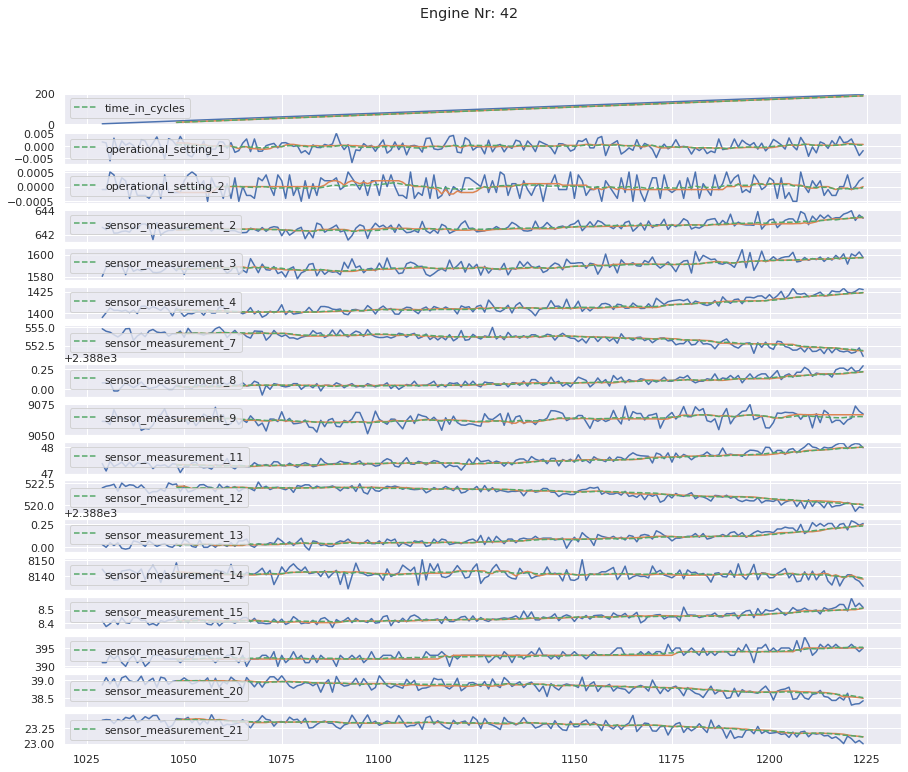

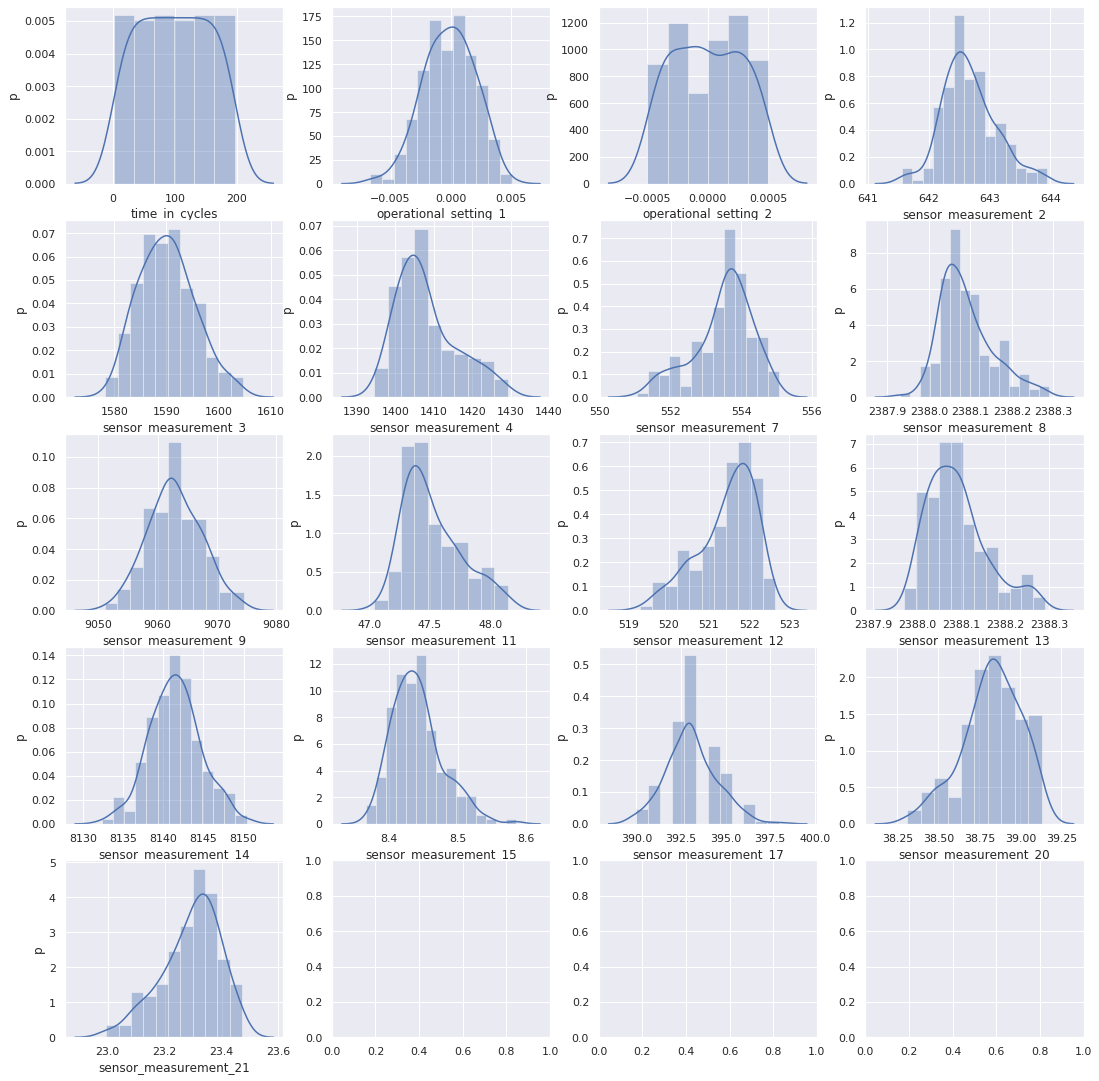

In [101]:
# plot engine with the shortest cycles
plot_engine(shortest_engine)

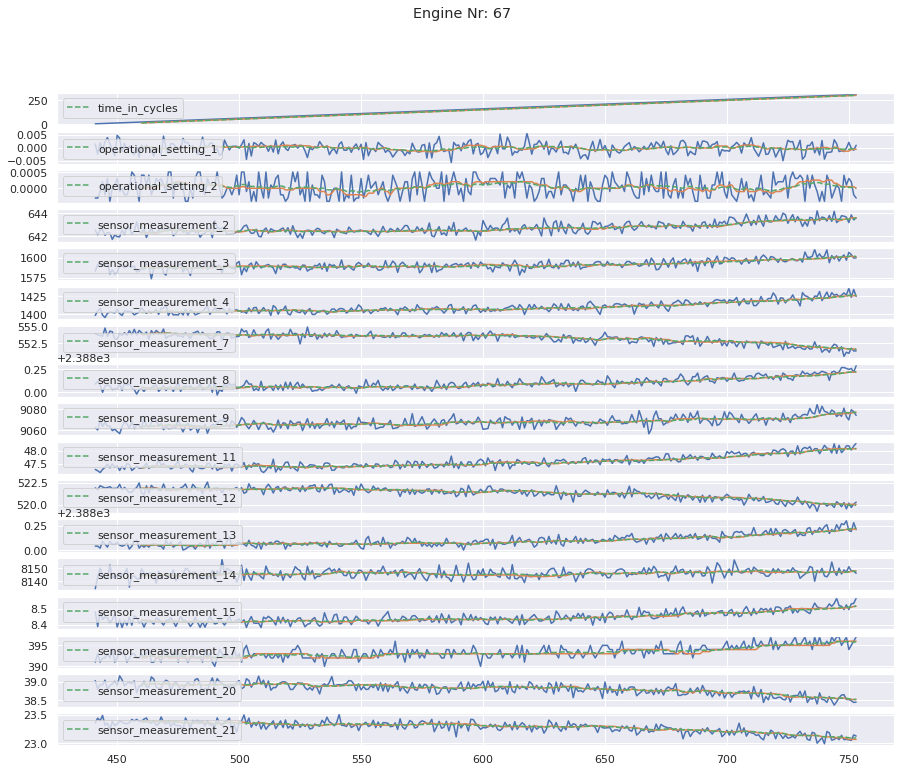

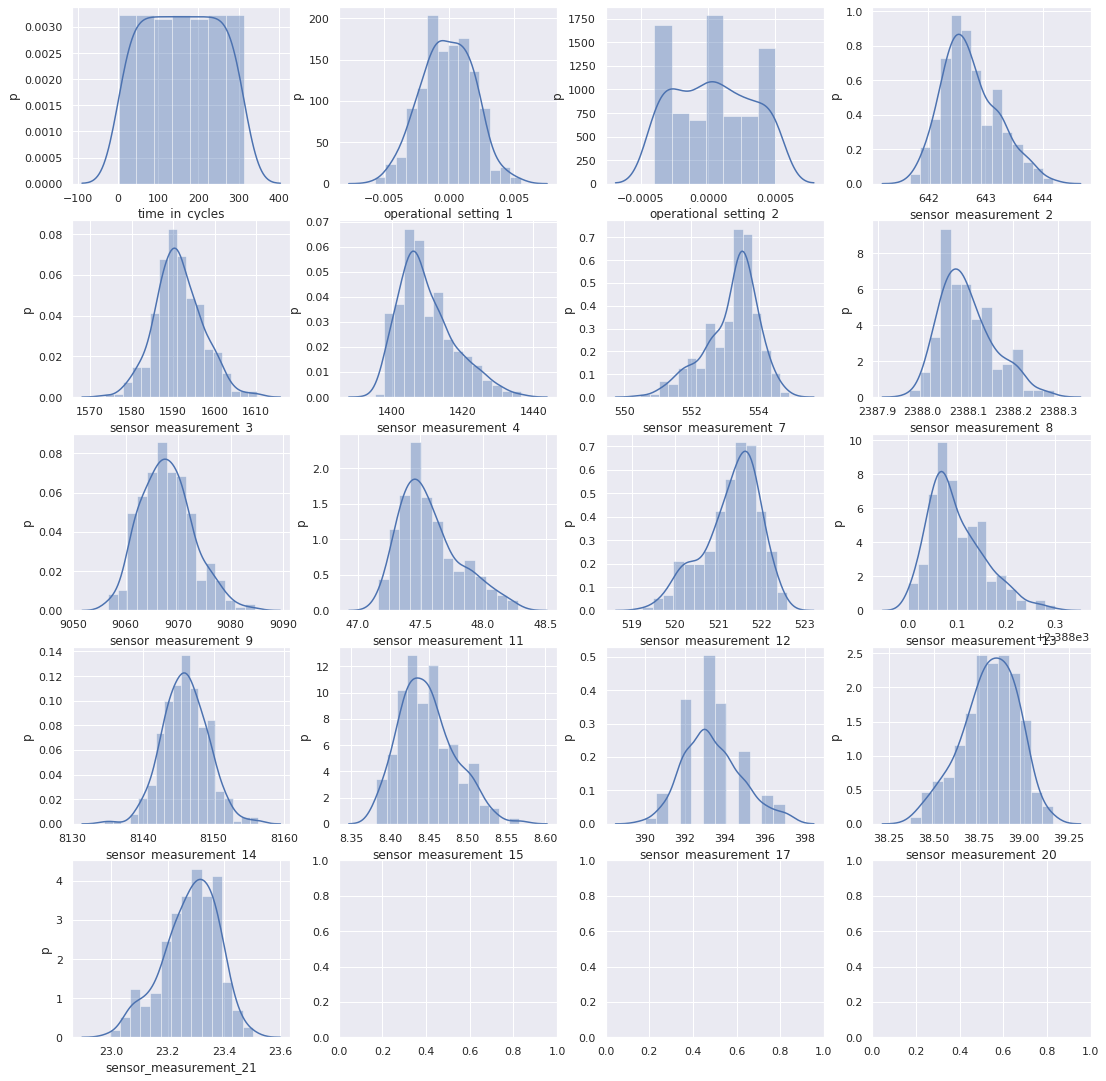

In [102]:
# plot engine with the longest cycles
plot_engine(longest_engine)

Let´s have a look at the number of cycles the engines run before a failure.

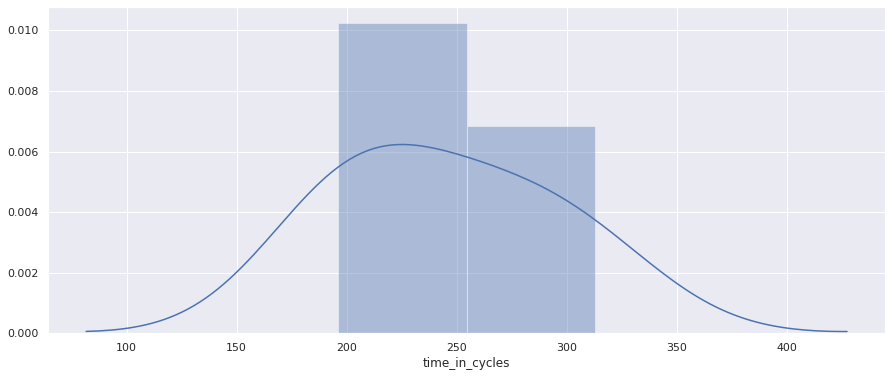

In [23]:
cycles_per_engine = train_data.groupby(['engine_no'], sort=False)['time_in_cycles'].max()
fig = plt.figure(figsize=(15, 6))
ax2 = sns.distplot(pd.Series(cycles_per_engine) ,label='operation times')